In [1]:
# Add the path of the beer source code ot the PYTHONPATH.
from collections import defaultdict
import random
import sys
sys.path.insert(0, '../')
from beer import __init__

import copy

import beer
import numpy as np
import torch

# For plotting.
from bokeh.io import show, output_notebook, export_png
from bokeh.plotting import figure, gridplot
from bokeh.models import LinearAxis, Range1d
output_notebook()

# Convenience functions for plotting.
import examples.plotting as plotting

Loading BokehJS ...

### Set GPU

In [2]:
torch.cuda.set_device("cuda:3")
torch.cuda.current_device()
# device = torch.device("cuda:5")
# xxx.to(device)

3

### Synthetic Data
Multiview Data with two different series of means.

In [3]:
import examples.synthetic_data as synthetic_data
data, states = synthetic_data.generate_multiview_sequential_data()

### Construct Graph
This graph describe the transformation of hidden state.

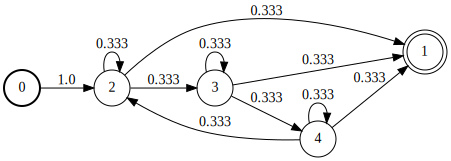

In [4]:
import examples.make_graph as make_graph
graph = make_graph.construct_graph()
graph

In [5]:
cgraph = graph.compile()
cgraph.final_log_probs

tensor([-1.0986, -1.0986, -1.0986])

### Construct HMM 

In [6]:
# We use the global mean/cov. matrix of the data to initialize the mixture.
data_mean = torch.from_numpy(data[0].mean(axis=0)).float()
data_var = torch.from_numpy(np.cov(data[0].T)).float()

trans_mat = np.array([[.5, .5, 0], [0, .5, .5], [.5, 0, .5]])
init_states = torch.LongTensor([0])
final_states = torch.LongTensor([2])
transitions = torch.from_numpy(trans_mat).float()

# HMM (full cov).
modelset = beer.NormalSet.create(data_mean, data_var, size=len(transitions),
                                prior_strength=1., noise_std=0, 
                                cov_type='full')
hmm_full = beer.HMM.create(cgraph, modelset).double().cuda()

hmm_full

HMM(
  (modelset): DynamicallyOrderedModelSet(
    (original_modelset): NormalSet(
      (means_precisions): ConjugateBayesianParameter(prior=NormalWishart, posterior=NormalWishart)
    )
  )
  (graph): <CompiledGraph>
)

In [7]:
fig = figure(width=250, height=250)
fig.circle(data[0][:, 0], data[0][:, 1], alpha=.1)
fig.circle(data[1][:, 0], data[1][:, 1], alpha=.1, color='gray')
show(fig)

### Train VAE

In [8]:
X = torch.from_numpy(data).cuda()

In [9]:
enc1 = beer.nnet.ResidualFeedForwardNet(dim_in=2, nblocks=2, block_width=2)
dec1 = beer.nnet.ResidualFeedForwardNet(dim_in=2, nblocks=2, block_width=2)
enc2 = beer.nnet.ResidualFeedForwardNet(dim_in=2, nblocks=2, block_width=2)
dec2 = beer.nnet.ResidualFeedForwardNet(dim_in=2, nblocks=2, block_width=2)
vae = beer.MvVAE(hmm_full, enc1, dec1, enc2, dec2).double().cuda()

In [10]:
# small number of epochs for testing
epochs = 1000
update_prior_after_epoch = 50
prior_lrate = 1.
cjg_optim = beer.VBConjugateOptimizer(vae.mean_field_factorization(), lrate=0)
std_optim = torch.optim.Adam(vae.parameters(), lr=1e-3)
optim = beer.VBOptimizer(cjg_optim, std_optim)

In [11]:
elbos = []
for e in range(epochs):
    optim.init_step()
    elbo = beer.evidence_lower_bound(vae, X, nsamples=5, kl_weight=0.8)
    elbo.backward()
    optim.step()
    if e >= update_prior_after_epoch:
        cjg_optim.lrate = prior_lrate
    if e % 50 == 0:
        elbos.append(float(elbo) / len(X))
    if e % 50 == 0:
        post = vae.posteriors(X)
        fig = figure(title='', width=250, height=250)
        m = post.params.mean.data.clone().cpu().numpy()
        fig.circle(m[:, 0], m[:, 1], alpha=.1)
        plotting.plot_hmm(fig, vae.prior, alpha=.3, colors=['blue', 'red', 'green'])
        show(fig)

In [12]:
fig = figure()
fig.line(range(len(elbos[:])), elbos[:])
show(fig)
elbos[-1]

-698005.6843604107

In [13]:
fig = figure(title='', width=250, height=250)
post = vae.posteriors(X)
m = post.sample(1).data.clone().cpu().numpy().reshape(-1, 2)
# m = post.params.mean.data.clone().cpu().numpy()
fig.circle(m[:, 0], m[:, 1], alpha=.1)
plotting.plot_hmm(fig, vae.prior.cpu(), alpha=.3, colors=['blue', 'red', 'green'])
show(fig)

In [14]:
fig = figure(title='', width=250, height=250)
post = vae.posteriors(X)
m = post.params.mean.data.clone().cpu().numpy()
fig.circle(m[:, 0], m[:, 1], alpha=.1)
show(fig)

In [15]:
fig = figure(title='', width=250, height=250)
post = vae.posteriors(X)
m = post.sample(1).data.clone().cpu().numpy().reshape(-1, 2)
fig.circle(m[:, 0], m[:, 1], alpha=.1)
show(fig)

In [16]:
fig = figure(title='', width=250, height=250)
post = vae.posteriors(X)
h = post.sample(1).reshape(-1, 2)
pdf = vae.pdfs(h, 1)
m = pdf.params.mean.data.clone().cpu().numpy()
fig.circle(m[:, 0], m[:, 1], alpha=.1)
show(fig)

In [17]:
fig = figure(title='', width=250, height=250)
post = vae.posteriors(X)
h = post.sample(1).reshape(-1, 2)
pdf = vae.pdfs(h, 1)
m = pdf.sample(1).data.clone().cpu().numpy().reshape(-1, 2)
fig.circle(m[:, 0], m[:, 1], alpha=.1)
show(fig)

In [18]:
state_seq = vae.prior.decode(post.params.mean.clone().cpu())
torch.eq((state_seq)%3, torch.from_numpy(states))

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

### Save Model

In [19]:
torch.save(vae.state_dict(), 'mvhmm-vae-cuda.pkl')

### Load Model

In [20]:
vae.load_state_dict(torch.load('mvhmm-vae-cuda.pkl'))

<All keys matched successfully>